#### Interpretability methods
###### Packages

In [8]:
# Data manipulation
import pandas as pd
import numpy as np
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Metric and model form scikit-learn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
# Boosting model
import catboost as cb
import lightgbm as lgb
import xgboost as xgb
# Tuning optimization
import optuna
import optuna.visualization as vis
# System utilities
import warnings
warnings.filterwarnings("ignore")
import sys
print(sys.executable)


c:\Users\maria\AppData\Local\Programs\Python\Python312\python.exe


#### The Dataset

In [2]:
df = pd.read_csv(r"Churn_clean.csv") # Data cleaning and feature engineering done in Feature_Engineering.ipynb
df['Imp_Liquidita_Attuale']=df['Imp_Liquidit�_Attuale']
df=df.drop(columns=['Imp_Liquidit�_Attuale'])
df.head()

,Flag_Richiesta_Estinzione_cc,Imp_Valore_del_Cliente,Flag_Apertura_Conto_Online,Flag_Possesso_piu_Conti,Eta,Provincia_Domicilio,Provincia_Residenza,Anno_Apertura_primo_Conto,Professione,Imp_Reddito,...,Flag_Contatto_Call_Center,Flag_variazione_Accredito_Stipendio,Num_Punti_Programma_Loyalty,Imp_Gestito_attuale,Imp_Amministrato_attuale,Flag_Trasferimento_Titoli_Out,Flag_Rifiuto_Carte,Flag_Rifiuto_Prestiti,Flag_Disattivazione_RID,Imp_Liquidita_Attuale
0,no,65.03,0,0,38.0,BO,BO,2004.0,Impiegato,3.0,...,1.0,0.0,NaN,2978.40,2980.92,0,0,0,0,1634.57
1,no,138.88,0,0,45.0,SA,SA,2000.0,Impiegato,4.0,...,1.0,-1.0,325.0,NaN,34916.15,0,0,0,0,11918.26
2,no,546.54,0,0,61.0,VT,VT,2005.0,Altro/Nessuno,4.0,...,1.0,0.0,460.0,NaN,232776.62,1,0,0,0,2671.95
3,no,68.69,0,0,33.0,MI,MI,2010.0,Impiegato,2.0,...,0.0,-1.0,NaN,15013.53,15017.53,0,0,0,0,19211.31
4,no,2417.05,0,0,36.0,MI,MI,2001.0,Quadro,NaN,...,1.0,NaN,3650.0,NaN,NaN,0,0,0,0,1526.38


##### Preprocessing

In [3]:
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1}).astype(int)
XX = pd.get_dummies(X) 

def clean_feature_names(df):
    df.columns = [col.replace(' ', '_').replace('[', '').replace(']', '').replace('<', '') for col in df.columns]
    return df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # Split 4:5, random state to ensure reproducibility

XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False)) #Encoding of the categorical features
X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index] #division in train and test

# apply clean_feature_names
X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)

X_train, X_test = X_train.align(X_test, join='inner', axis=1) #alignment of train and test columns, to ensure that they have the same lenght

X_train_final = X_train
X_test_final = X_test
y_train_final = y_train
y_test_final = y_test

LightGBM 

In [10]:
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

best_params = {
    "n_estimators": 297,
    "learning_rate": 0.010065762501114987,
    "max_depth": 13,
    "num_leaves": 25,
    "min_child_samples": 28,
    "subsample": 0.9186047768818155,
    "subsample_freq": 5,
    "colsample_bytree": 0.8969786318428297,
    "reg_alpha": 0.9097824682690728,
    "reg_lambda": 0.6075396766185748,
    "max_bin": 289,
    'force_col_wise': True,
    'scale_pos_weight': scale_pos_weight,
    'verbosity': -1
}

best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train_final, y_train_final)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test_final)[:, 1]

y_pred = best_lgb_classifier.predict(X_test_final)

Recall: 0.821882951653944


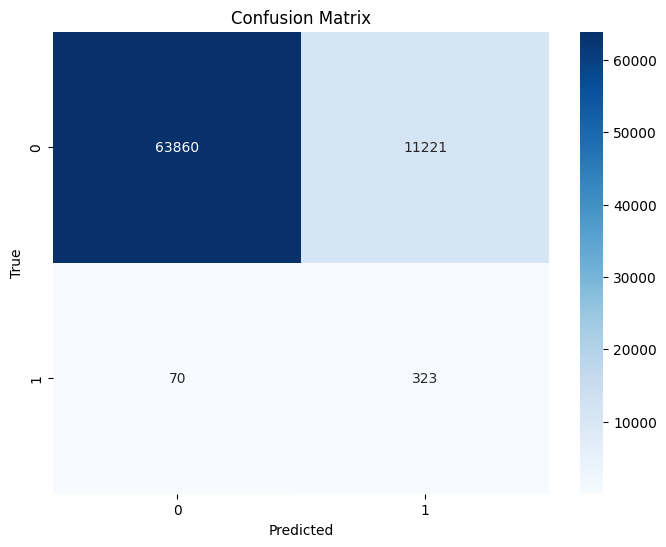

In [12]:
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

###### Feature importances

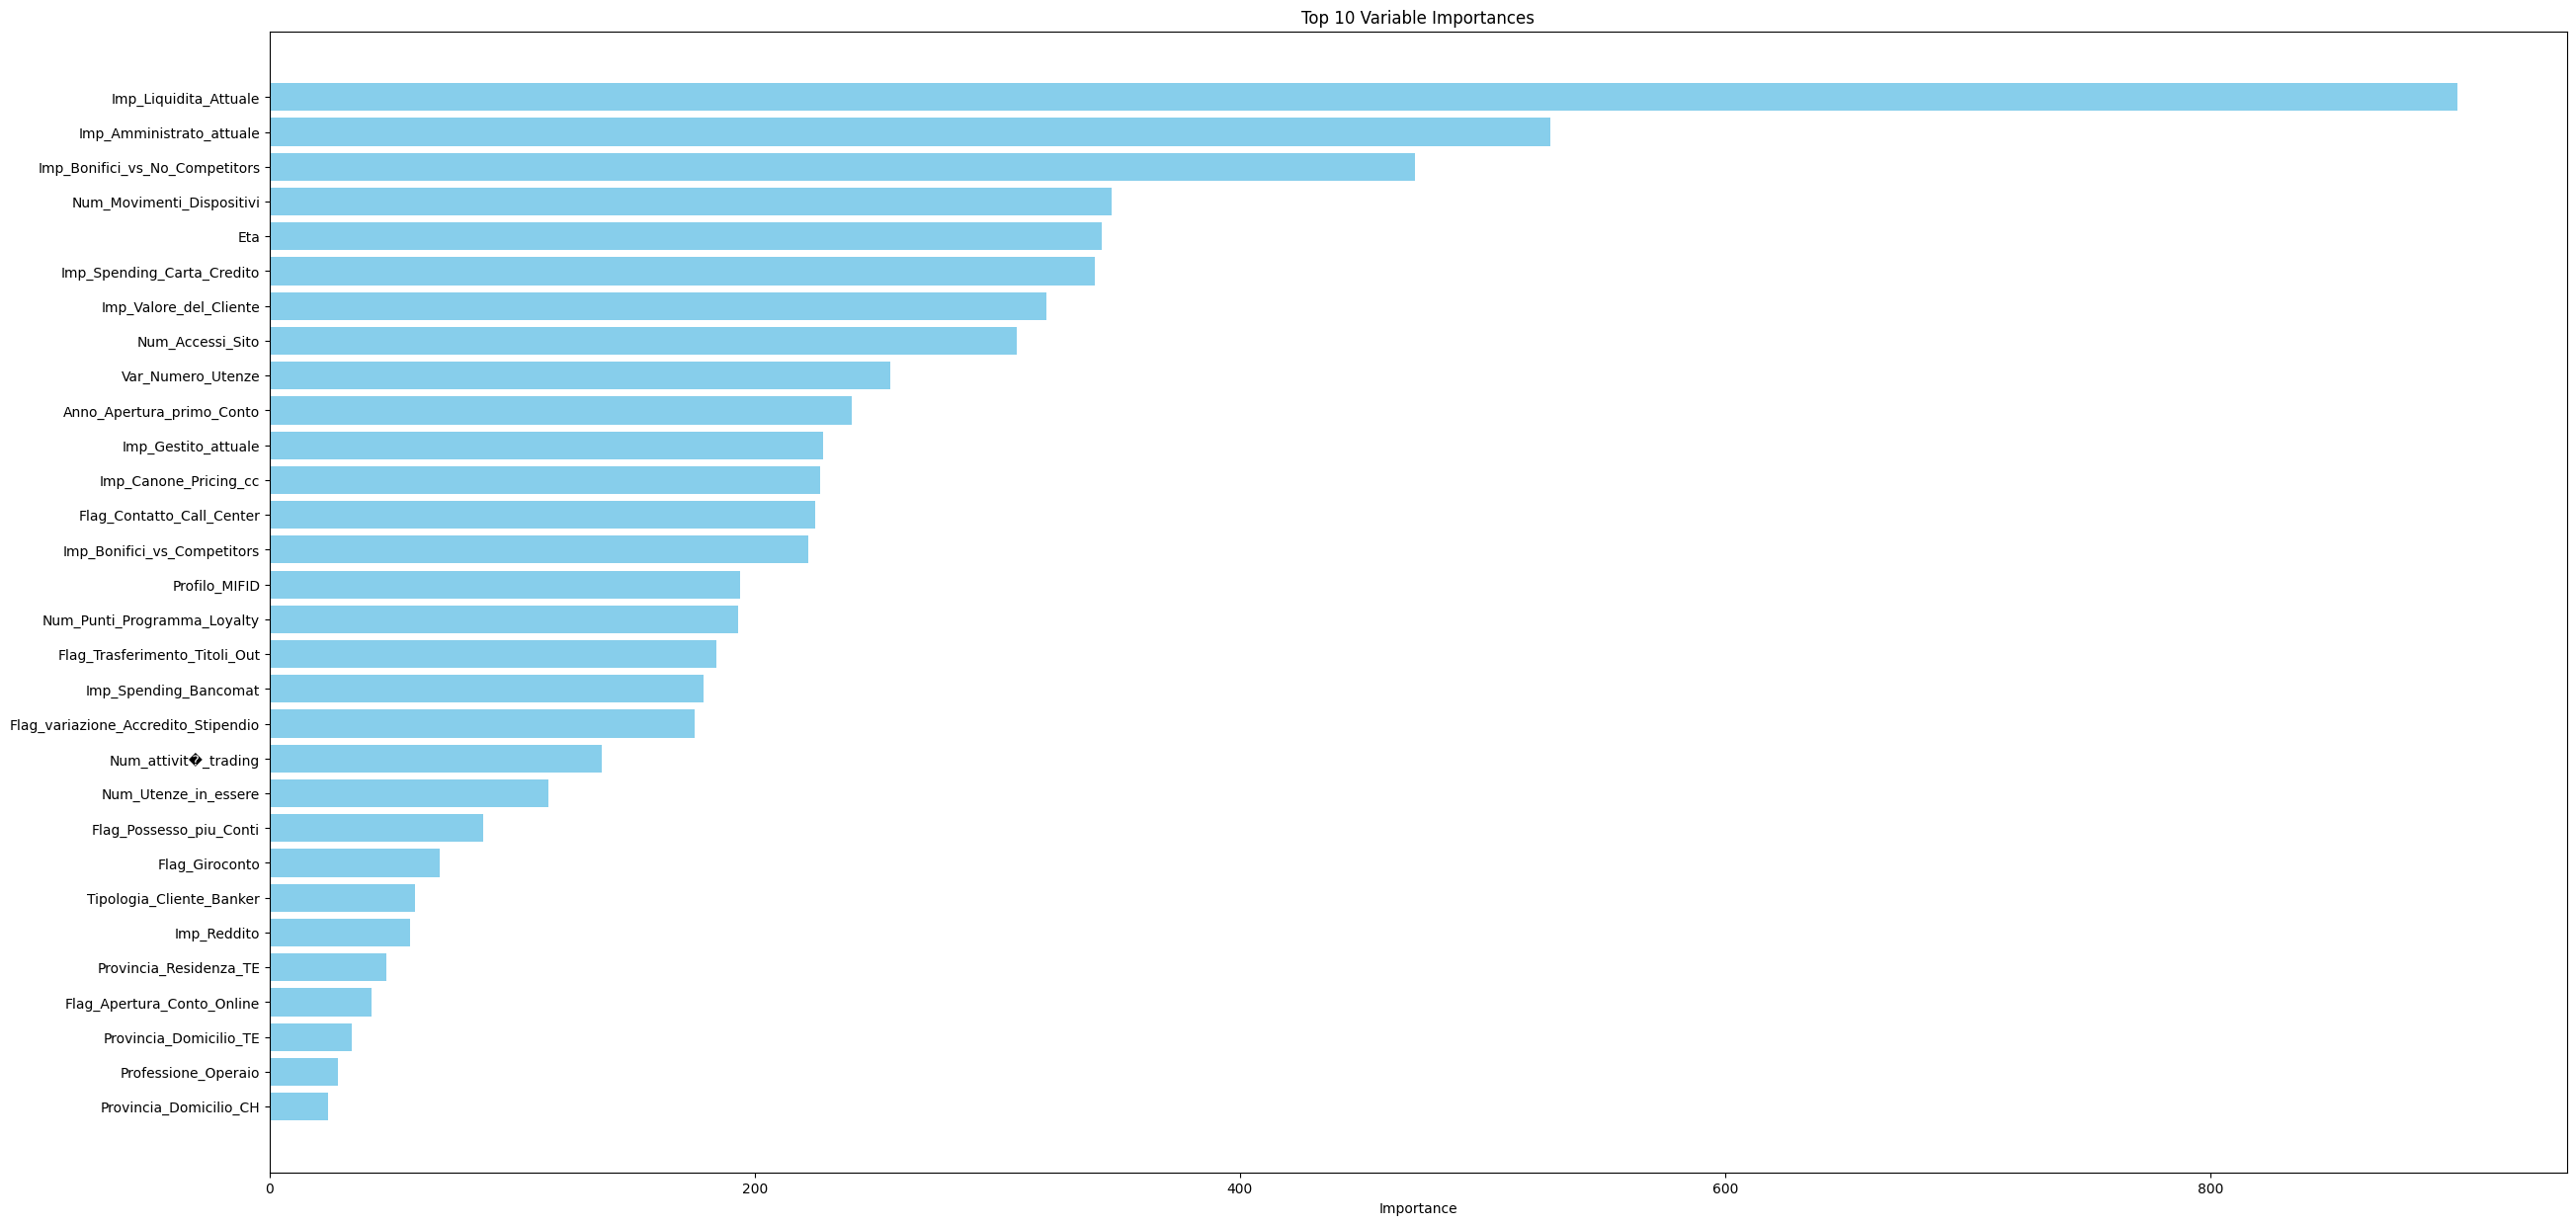

In [7]:
# Get feature importances
importance = best_lgb_classifier.feature_importances_

# Summarize feature importances
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(30, 15))
plt.barh(importance_df['Feature'].head(30), importance_df['Importance'].head(30), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()

###### Shapley values, each variable obtain a shapley value. The Shapley value calculates the fair contribution of each feature in a coalition by considering all possible orderings and averaging their marginal contributions across these orderings. This ensures that each feature is rewarded proportionally to their individual contribution to the coalition. 
###### In the shap summary plot, the most important features are showed: the length of the line is the level of importance of the feature, while the color explain if the feature contributes to an higher(red) or lower(blue) prediction.
###### For example, low shapley values for Imp_Liquidita_attuale identify a positive prediction for the target, so for the class 'yes'

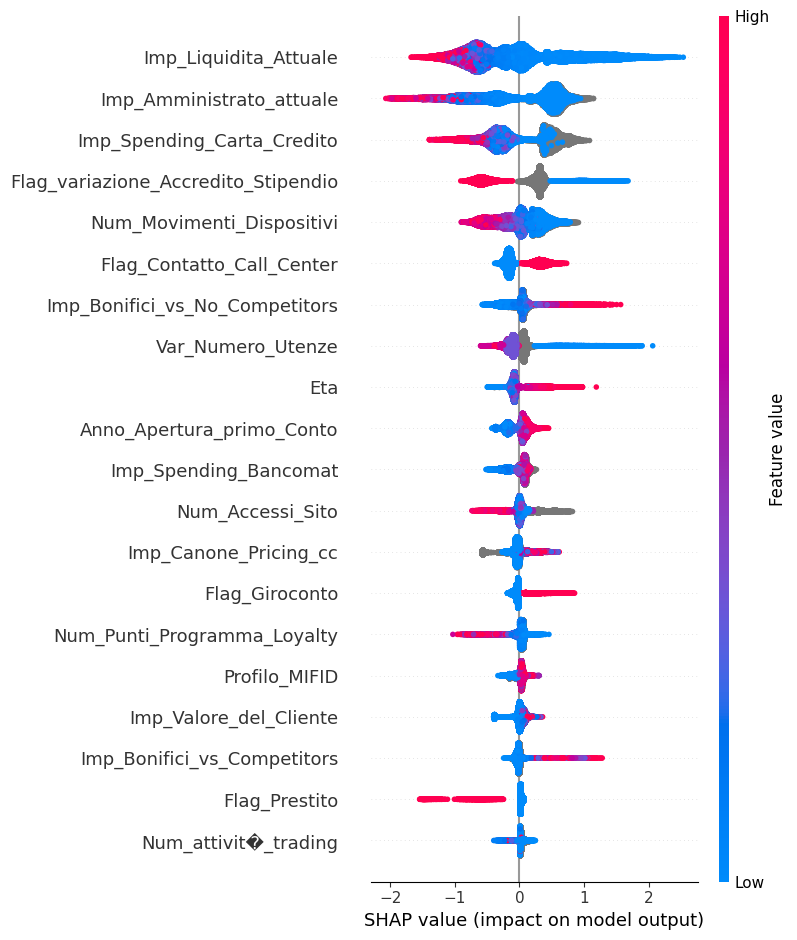

In [10]:
import shap
#Calcolo dei valori SHAP
explainer_shap = shap.TreeExplainer(best_lgb_classifier)
shap_values = explainer_shap(X_test_final)
expected_value = explainer_shap.expected_value #valore atteso delle predizioni del modello

# Genera il plot SHAP summary
shap.summary_plot(shap_values, X_test_final, title="SHAP summary plot")

###### Impact on model output for each instance
###### For example, low values of 'Imp_Liquidità_attuale' have a positive impact on the target, this mean that customers with less liquidity are closer to the class 'yes' in Flag_Richiesta_Estinzione_cc

###### The first five features that impact more on the model are Imp_Liqudita_Attuale, Imp_Amministrato_attuale, Imp_Spending_Carta_Credito, Flag_variazione_Accredito_Stipendio and Num_Movimenti_Dispositivi

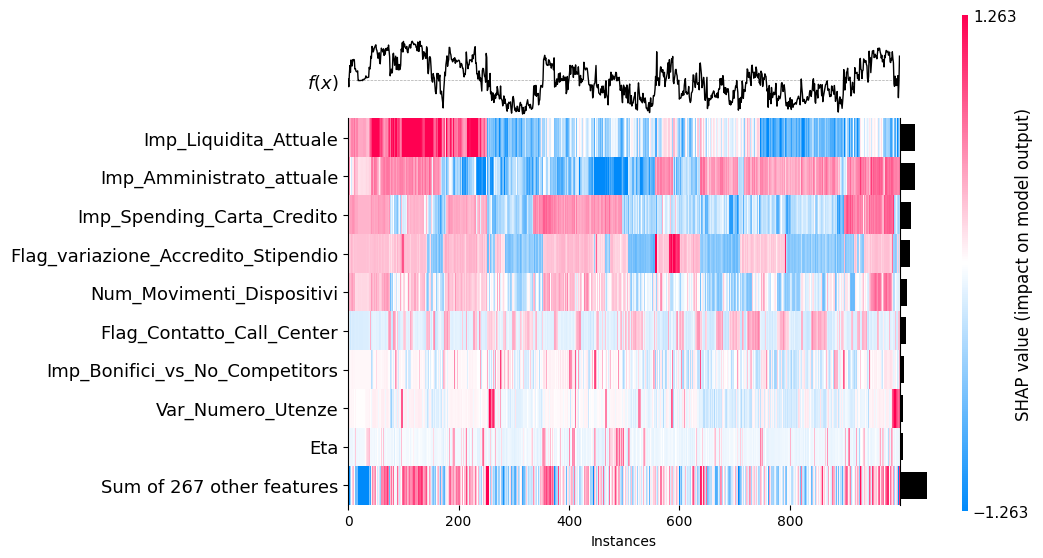

In [11]:
shap.plots.heatmap(shap_values[:1000])

###### High values of 'Imp_Liquidita_attuale' obtained a lower shapley value. This means that customers with higher liquidity difficulty require to close their account

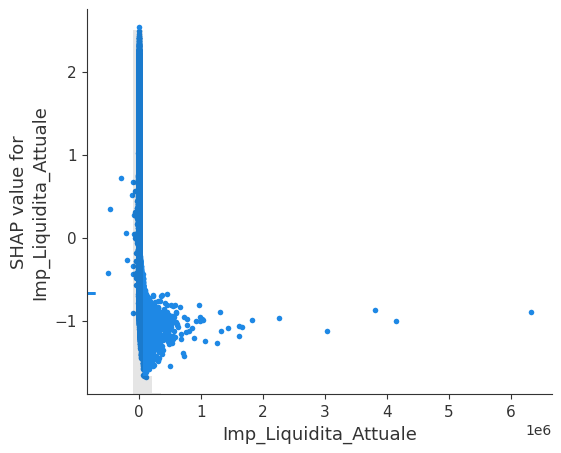

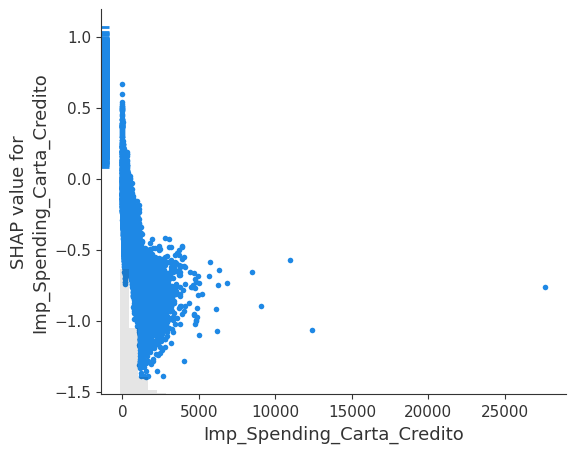

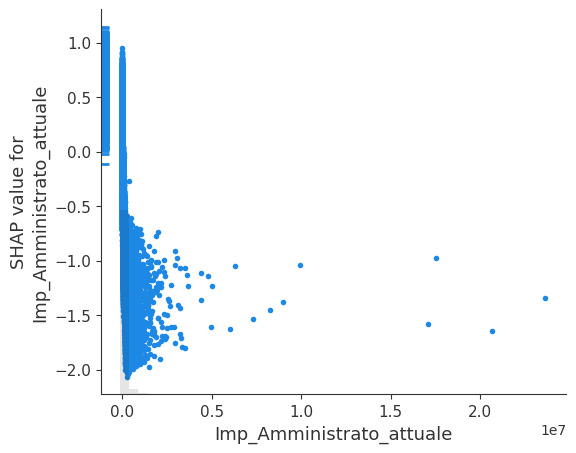

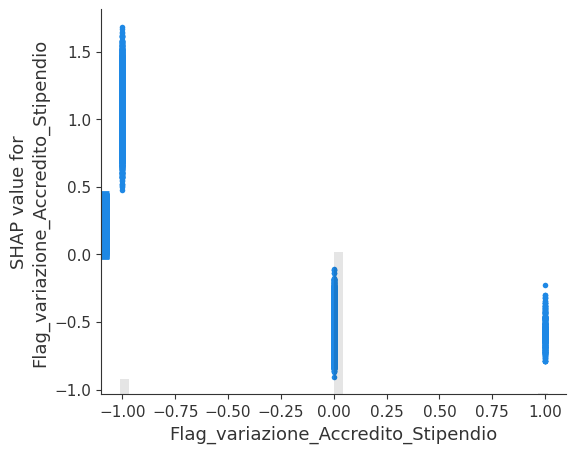

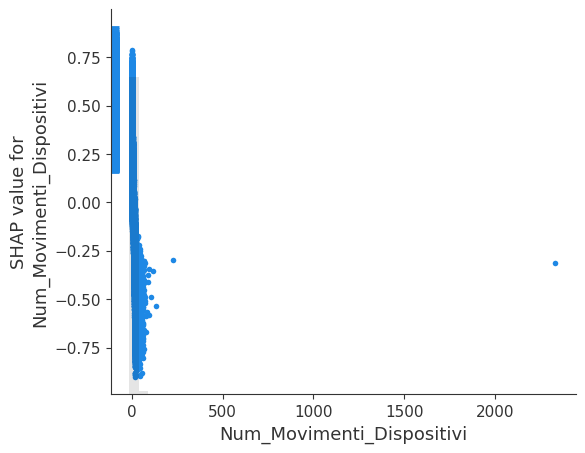

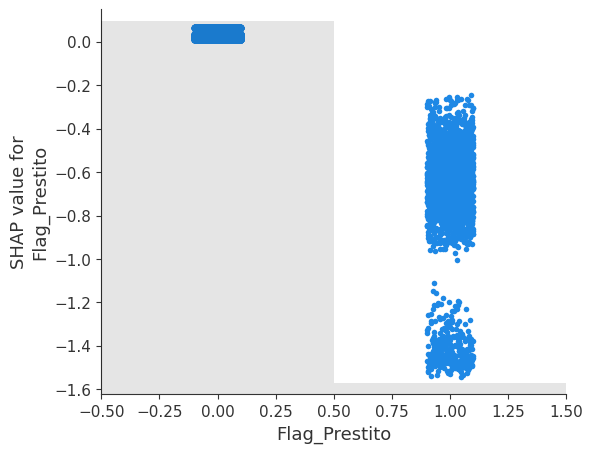

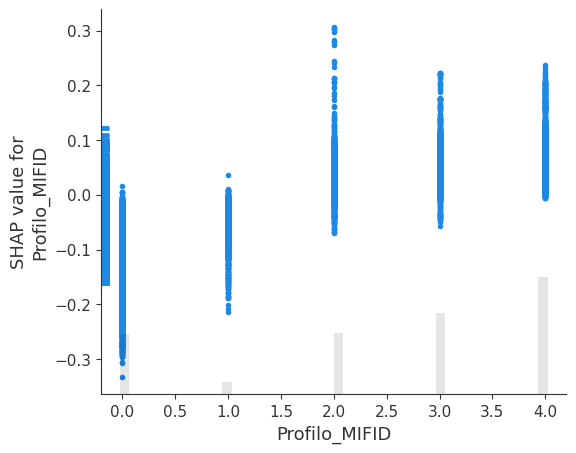

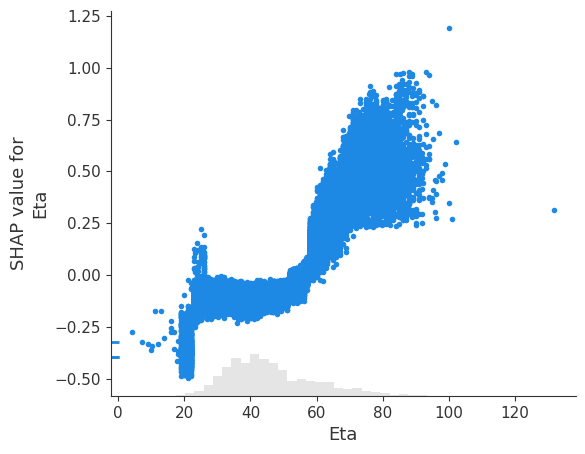

In [19]:
shap.plots.scatter(shap_values[:,"Imp_Liquidita_Attuale"])
shap.plots.scatter(shap_values[:,"Imp_Spending_Carta_Credito"])
shap.plots.scatter(shap_values[:,"Imp_Amministrato_attuale"])
shap.plots.scatter(shap_values[:,"Flag_variazione_Accredito_Stipendio"])
shap.plots.scatter(shap_values[:,"Num_Movimenti_Dispositivi"])
shap.plots.scatter(shap_values[:,"Flag_Prestito"])
shap.plots.scatter(shap_values[:,"Profilo_MIFID"])
shap.plots.scatter(shap_values[:,"Eta"])

In [27]:
predictions_proba = best_lgb_classifier.predict_proba(X_test_final)
positive_class_proba = predictions_proba[:, 1]
# Find FN
true_positive_indices = np.where((positive_class_proba > 0.5) & (y_test_final == 1))[0]

print("True positives instances:")
print(true_positive_indices)
print("Number of True positives: ",len(true_positive_indices))

True positives instances:
[    9   260   604   637  1531  1575  1726  2510  3181  3439  3721  3854
  3863  3887  4040  4171  4399  4501  4630  4912  5482  5564  5610  6117
  6404  6606  6782  6993  7194  7449  7481  8741  8795  9281  9287 11119
 11141 11204 11385 11579 11790 11928 12362 12399 12441 12924 12995 13329
 13355 13766 13890 14021 14498 14500 14807 14883 14979 15097 15167 15226
 15227 15510 15781 15848 15968 16060 16334 16947 16955 16974 16992 17442
 17568 17799 18088 18261 18270 18302 18513 18705 18971 19165 19305 19462
 19977 20007 20044 20118 20119 20322 20343 20591 21097 21744 21909 21932
 21937 22206 22322 22507 22595 22900 23133 23838 24114 24383 24729 24859
 25055 25322 25426 25606 25803 26372 27403 27634 27892 28270 28290 28928
 28954 29280 29529 29792 30276 30825 31457 31545 31803 32017 32483 32817
 32834 32872 33177 33503 33797 33949 34141 34365 34445 34760 35575 35758
 35822 36130 36565 36617 36857 36875 36912 37036 37064 37065 37066 37470
 37901 38088 38360 38389 

###### Identify the False negatives

In [18]:
predictions_proba = best_lgb_classifier.predict_proba(X_test_final)
positive_class_proba = predictions_proba[:, 1]
# Find FN
false_negatives_indices = np.where((positive_class_proba < 0.5) & (y_test_final == 1))[0]

print("False negatives instances:")
print(false_negatives_indices)
print("Number of False negatives: ",len(false_negatives_indices))

False negatives instances:
[   96  1056  2986  4685  6086  6394  7497  7603  9251 10044 11419 11873
 12419 12571 12988 15315 15573 19144 19729 19801 21090 21565 23540 26712
 26958 26980 27472 30085 32259 33402 33470 34677 35160 36041 36121 36377
 36841 37062 38016 41039 41371 42014 42311 45008 46532 48035 49245 49400
 49911 51375 52088 53663 55536 56767 64091 64287 65473 65734 66450 66671
 66926 67255 68041 70086 70349 70646 70906 71181 73104 73389]
Number of False negatives:  70


##### Local Interpretability with Shapley values
###### Imp_Amministrato_attuale, Flag_Variazione_Accredito_Stipendio and Imp_Liquidita_Attuale are some of the most important features. First there are 10 shap plots waterfall, for representing the attitude of some True Positives. When the three features impact negatively, the prediction is often negative, while when thir impact is positives, the prediction is often positive.

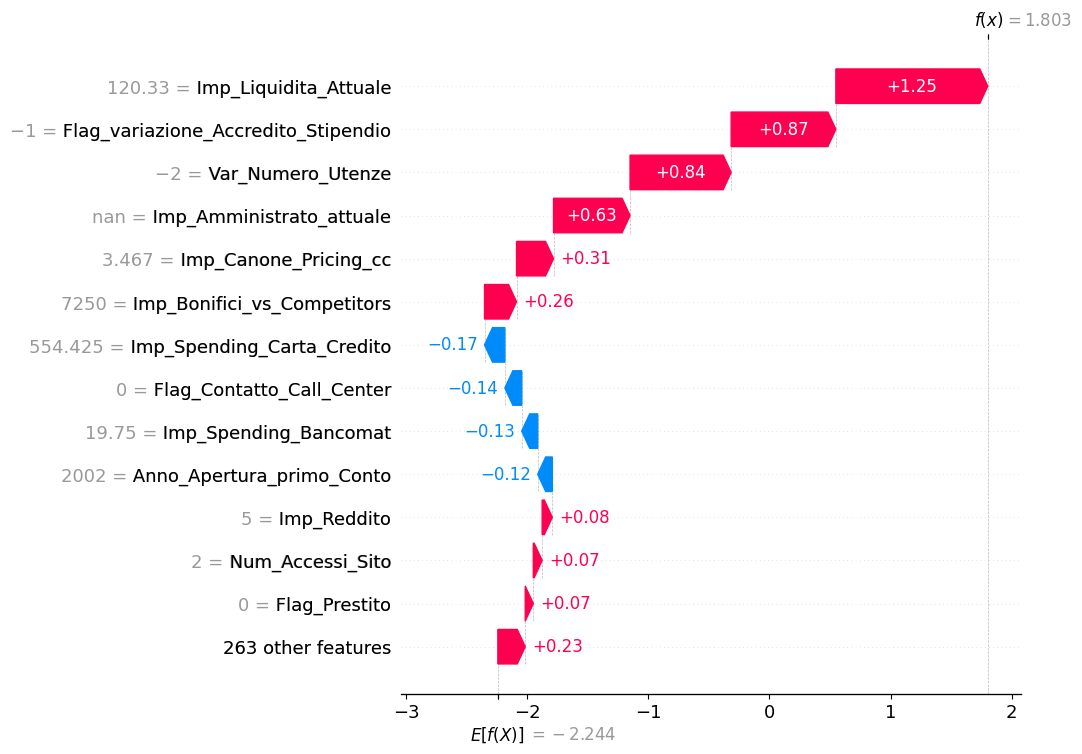

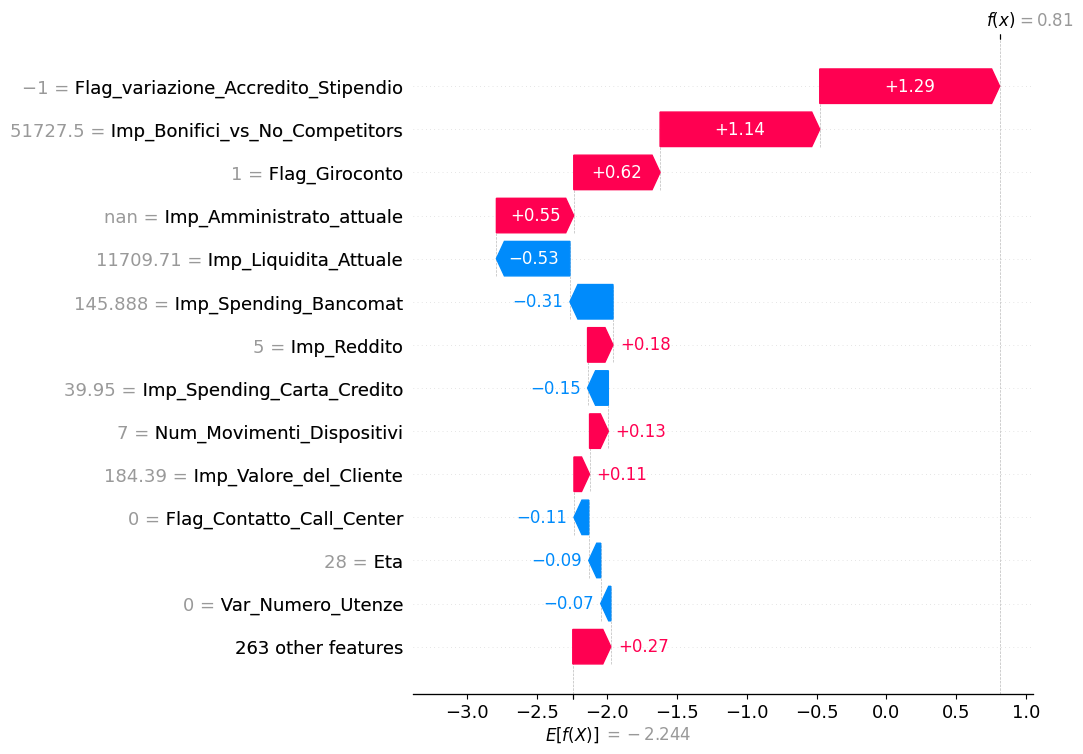

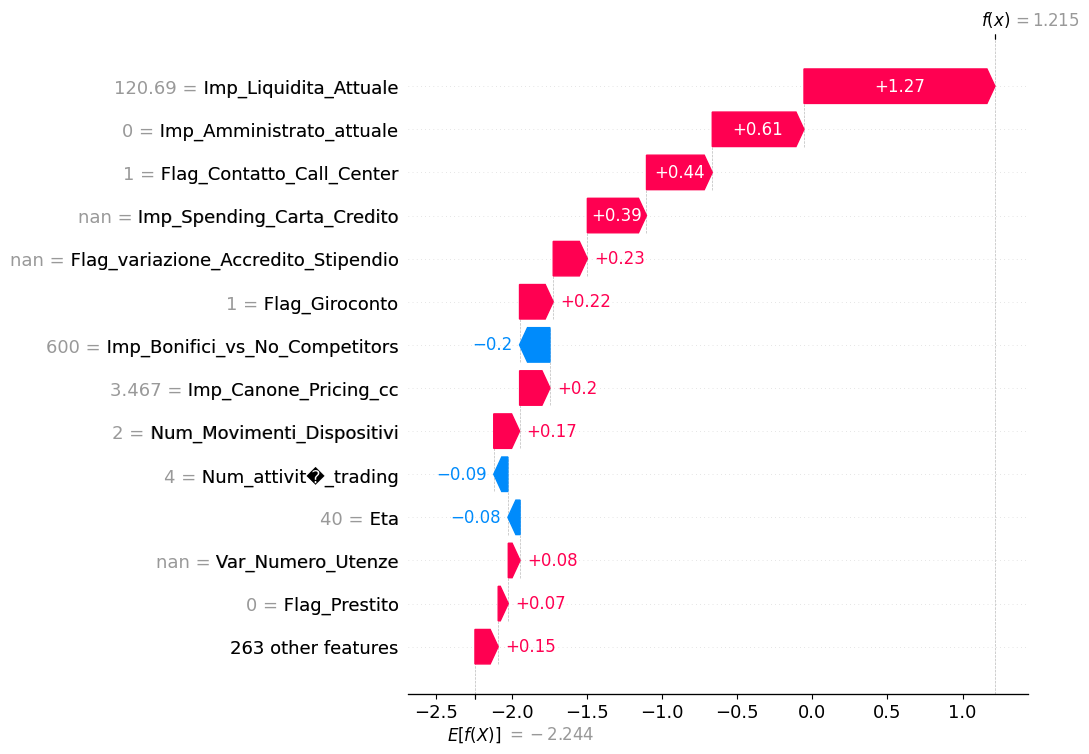

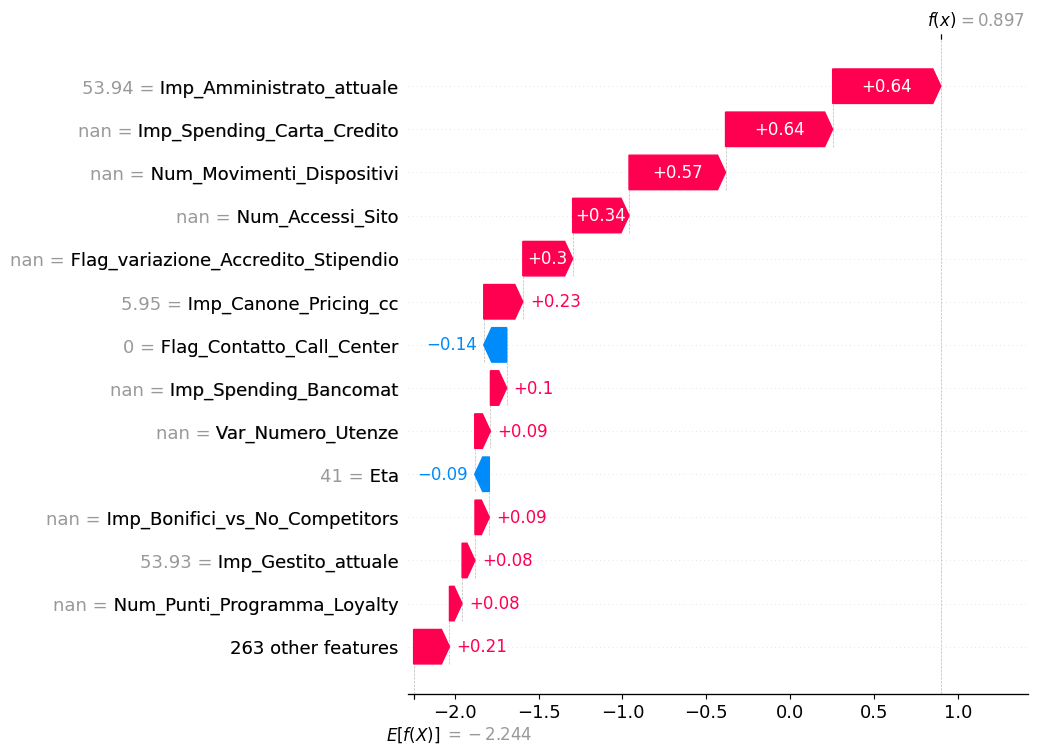

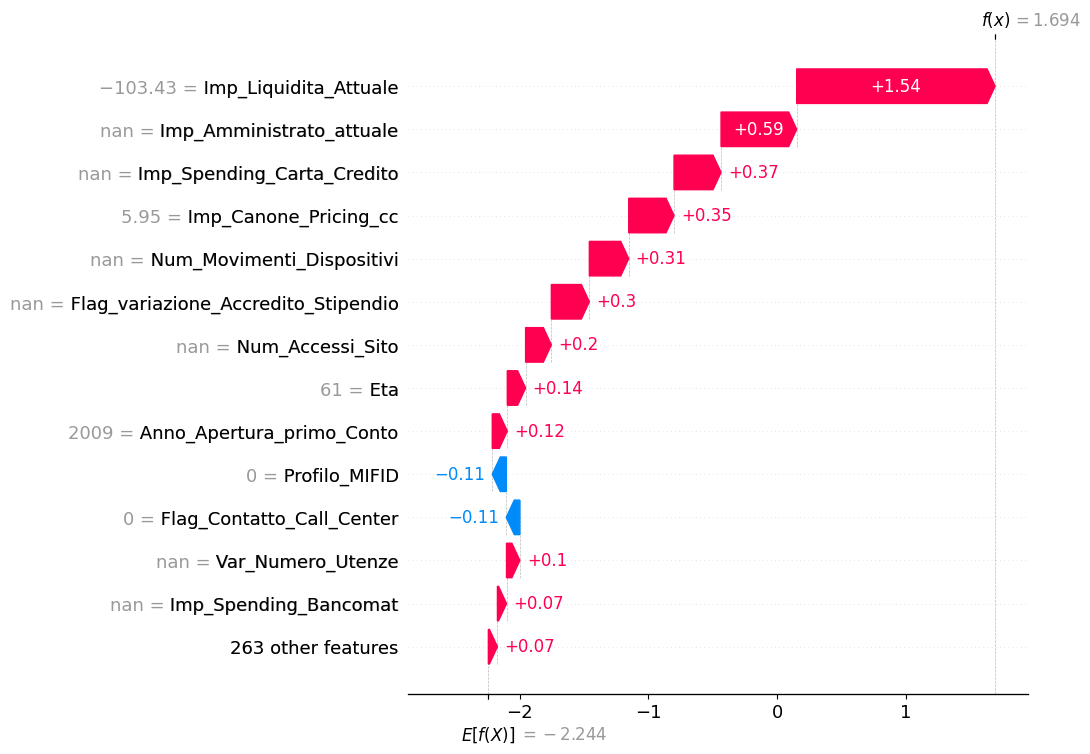

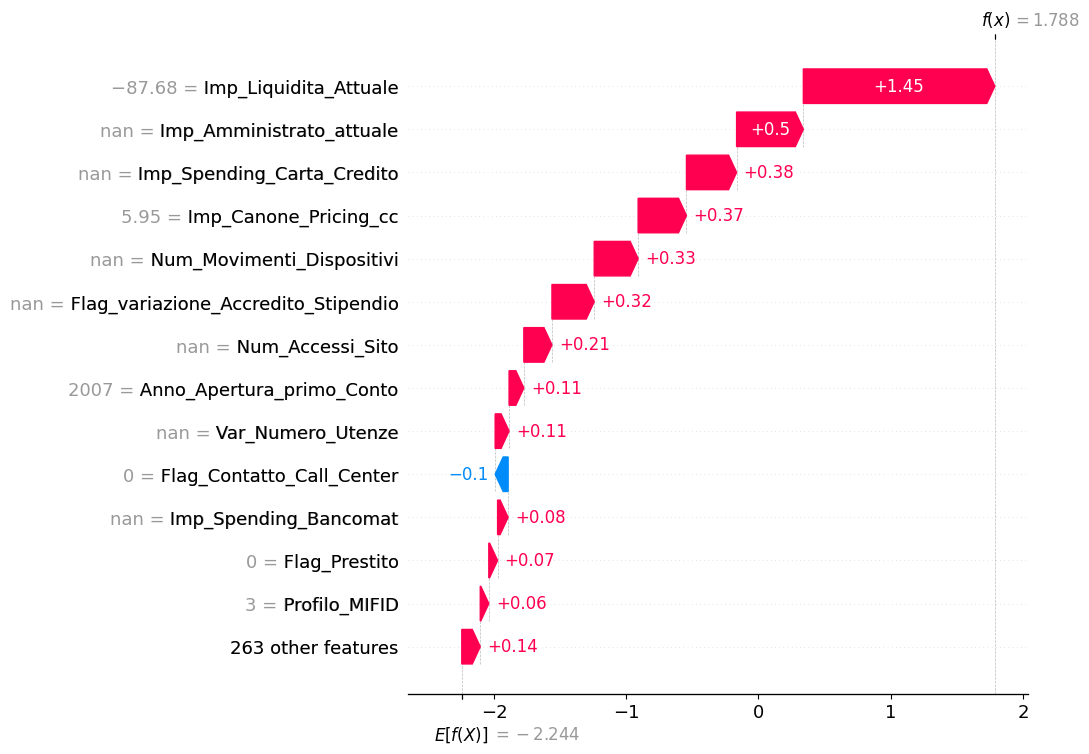

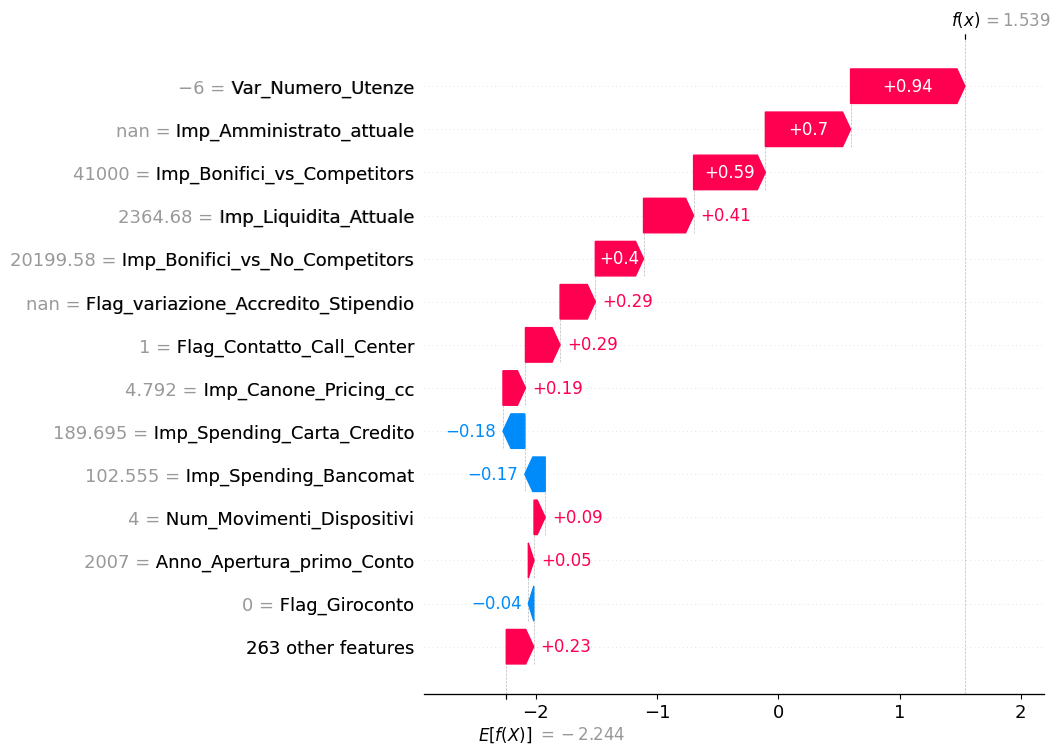

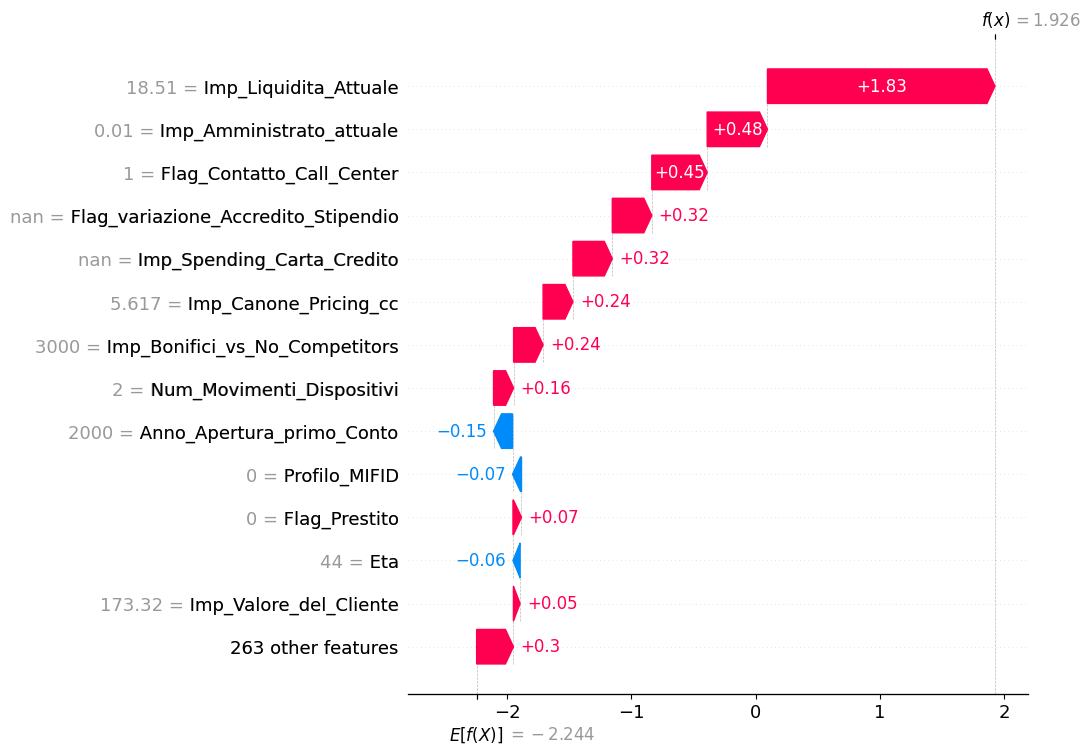

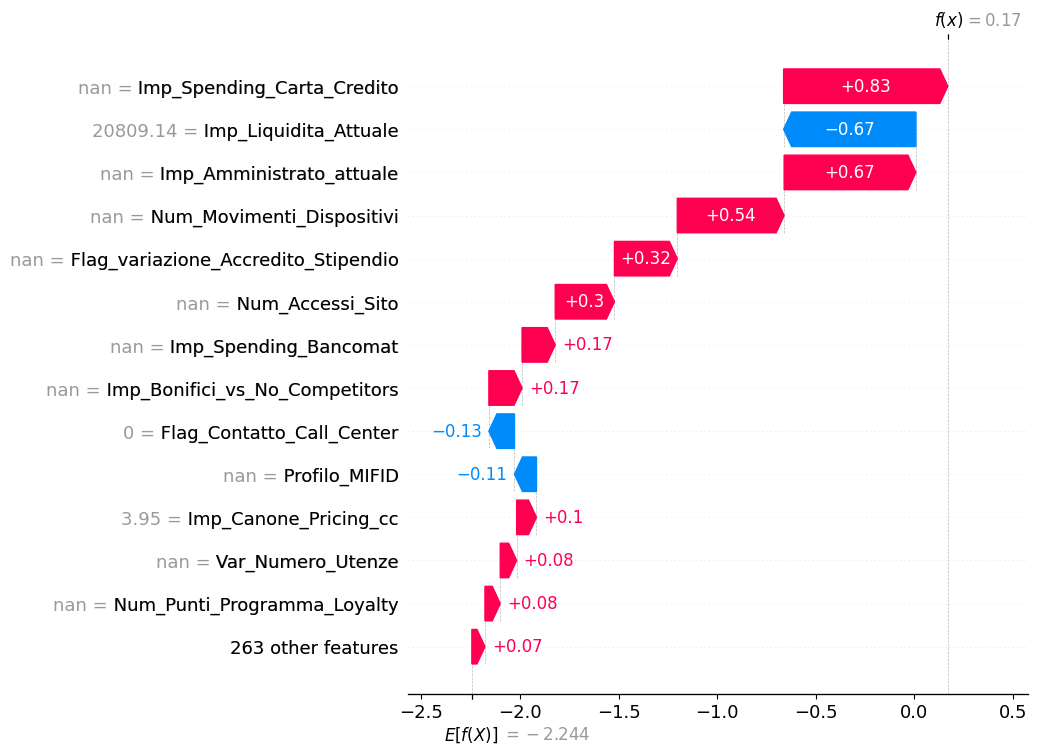

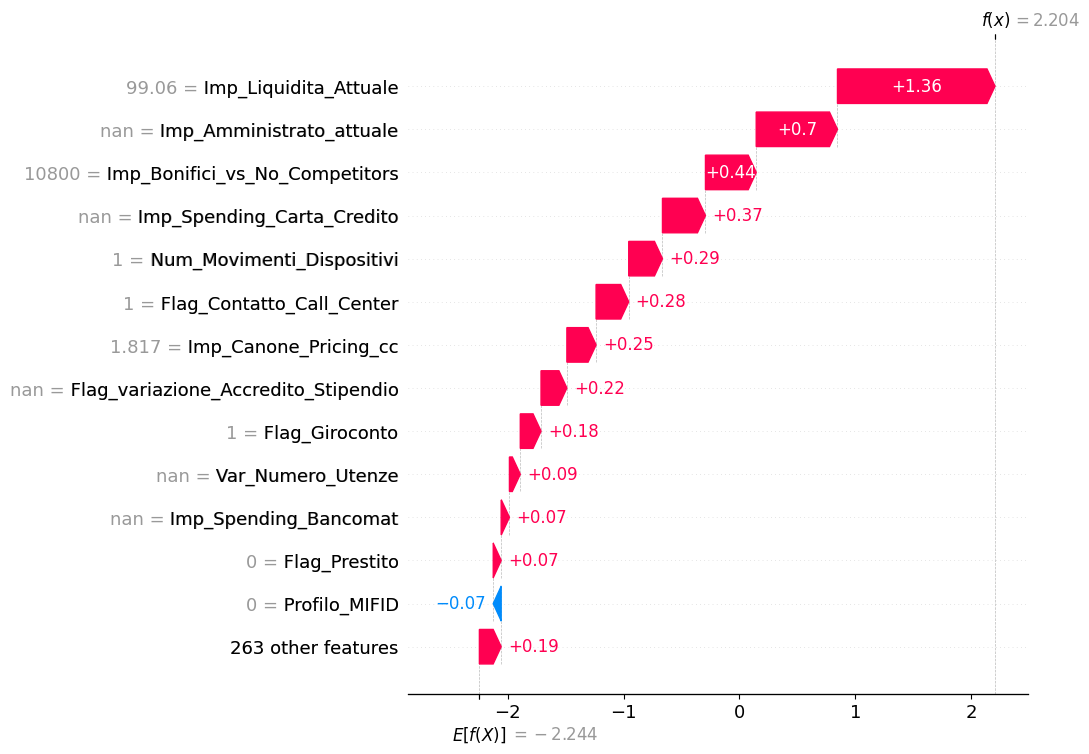

In [28]:
shap.plots.waterfall(shap_values[9], max_display=14)
shap.plots.waterfall(shap_values[260], max_display=14)
shap.plots.waterfall(shap_values[604], max_display=14)
shap.plots.waterfall(shap_values[637], max_display=14)
shap.plots.waterfall(shap_values[1531], max_display=14)
shap.plots.waterfall(shap_values[1575], max_display=14)
shap.plots.waterfall(shap_values[1726], max_display=14)
shap.plots.waterfall(shap_values[2510], max_display=14)
shap.plots.waterfall(shap_values[3181], max_display=14)
shap.plots.waterfall(shap_values[3439], max_display=14)

###### When some of the most important features are missed and the impact of other features is considerable, there is a wrong classification for the positive class

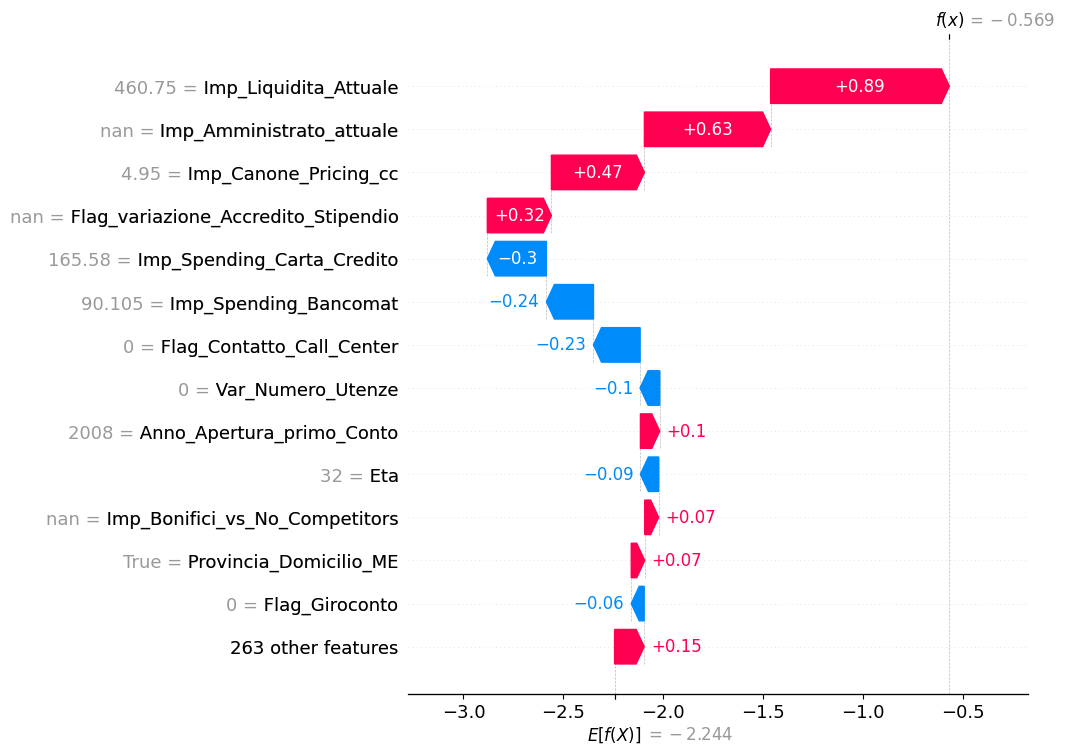

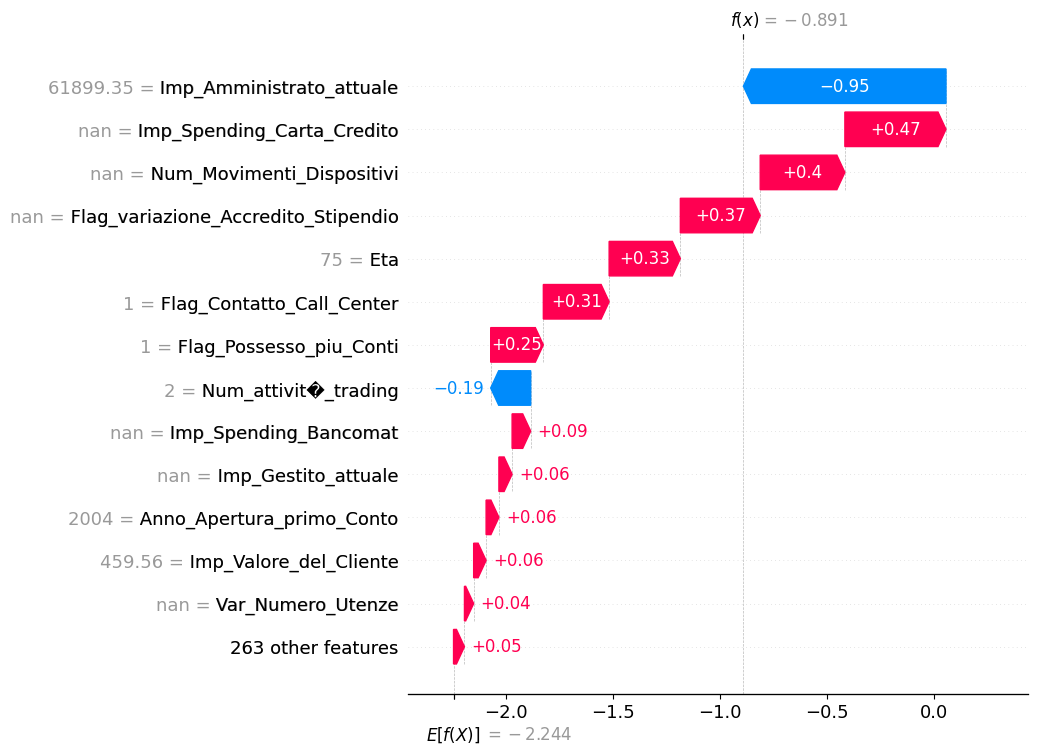

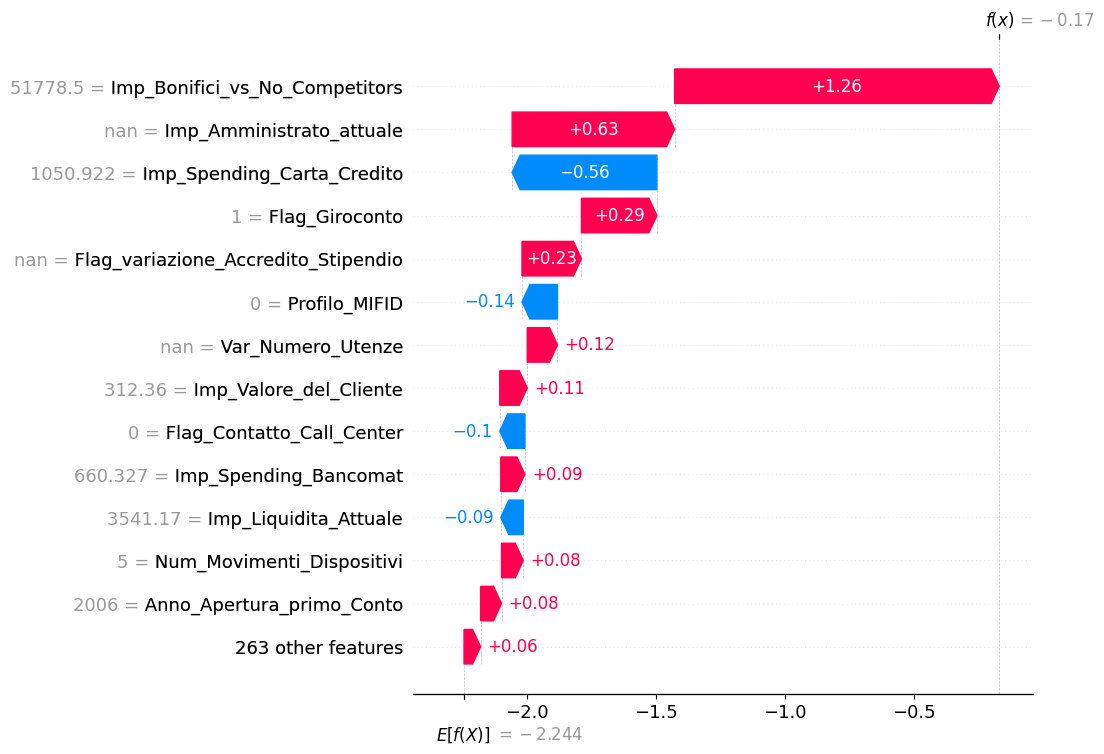

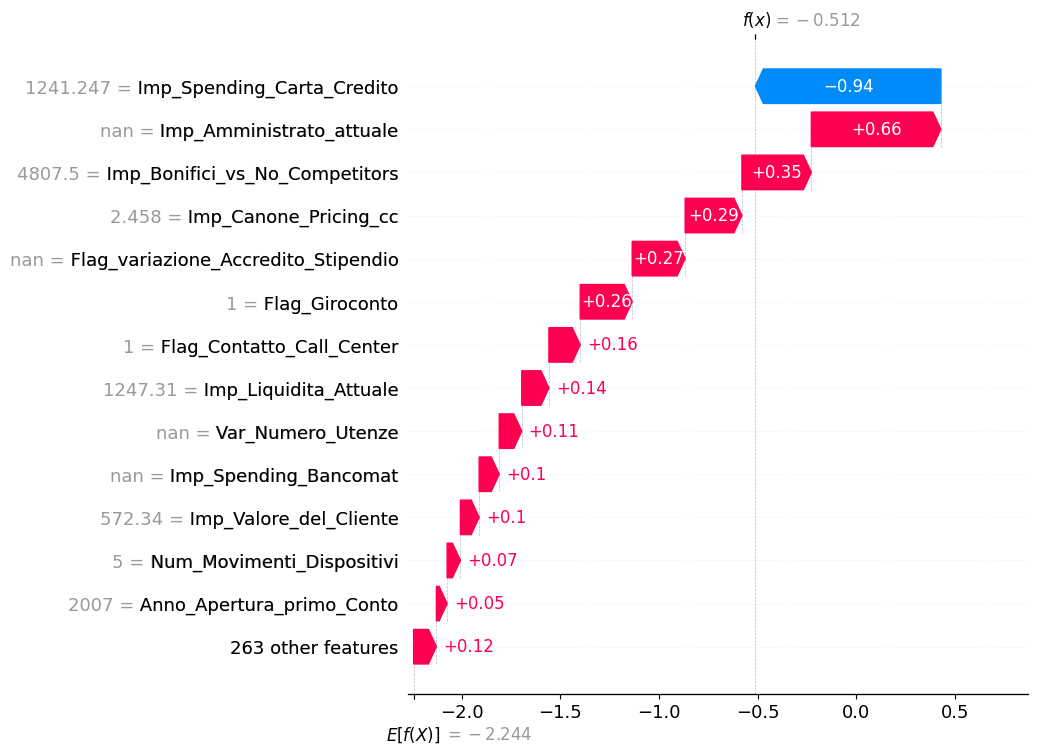

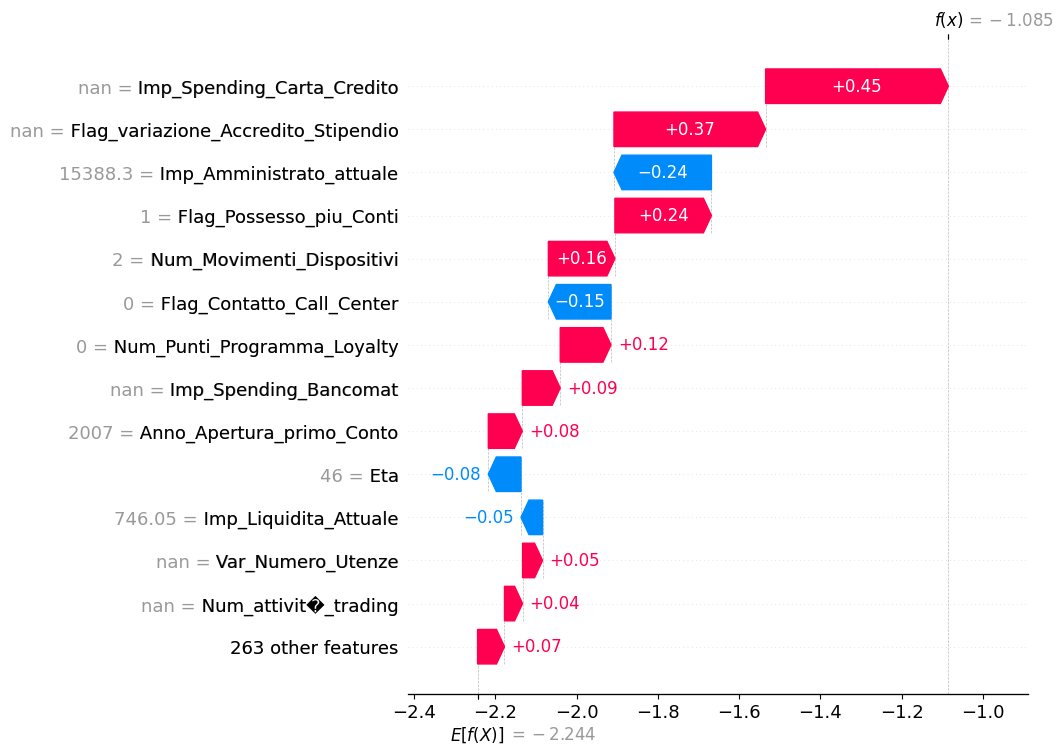

In [21]:
shap.plots.waterfall(shap_values[96], max_display=14)
shap.plots.waterfall(shap_values[1056], max_display=14)
shap.plots.waterfall(shap_values[2986], max_display=14)
shap.plots.waterfall(shap_values[4685], max_display=14)
shap.plots.waterfall(shap_values[6086], max_display=14)